Text(0.5, 0.01, 'Rest-frame days from g-max')

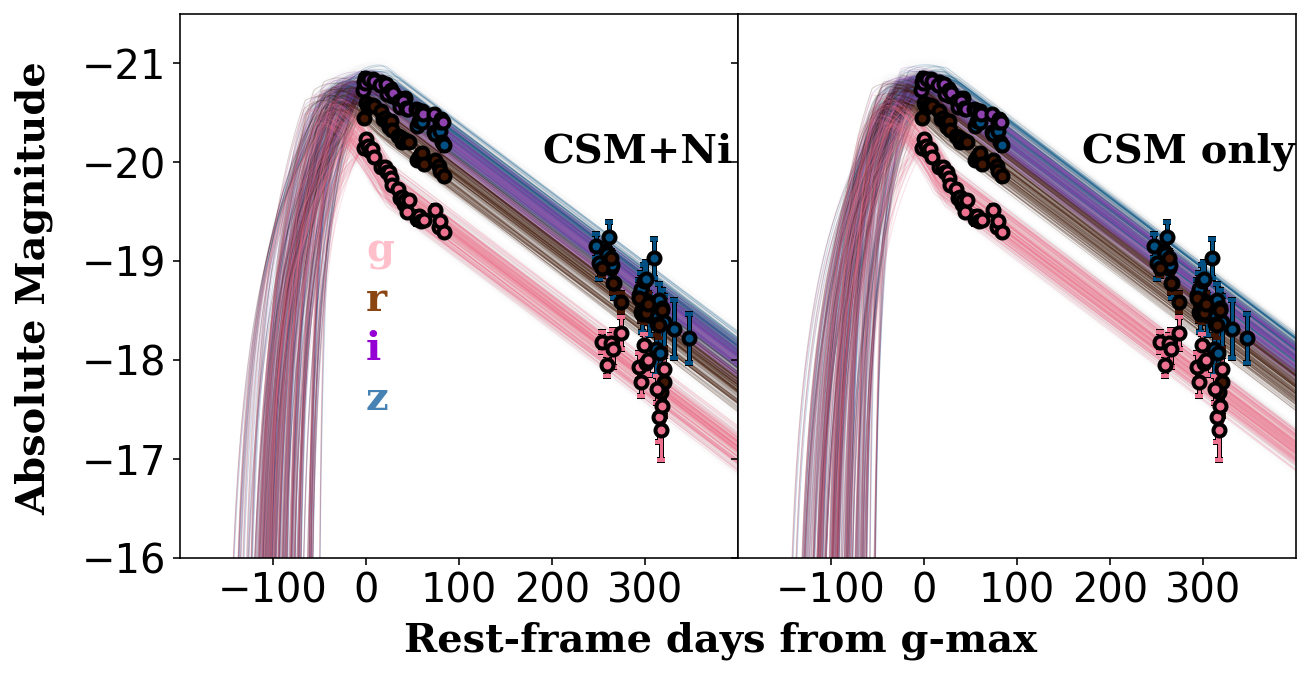

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import mosfit
import corner
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook
from collections import OrderedDict
from mosfit.plotting import bandcolorf


sns.reset_orig()
#fig = fig.add_subplot(111) 
fig, axs = plt.subplots(1, 2,figsize=(10,5), sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0})
(ax1, ax2) = axs

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 20})
from matplotlib import rc,rcParams
rc('font', weight='bold')
#ax1.show()

 #LC for griz + csm         
with open('walkers(copy)bcsmni.json', 'r', encoding = 'utf-8') as f2:
    data2 = json.loads(f2.read())
    if 'name' not in data2:
        data2 = data2[list(data2.keys())[0]]

photo = data2['photometry']
model = data2['models'][0]

real_data = len([x for x in photo if 'band' in x and 'magnitude' in x and (
    'realization' not in x or 'simulated' in x)]) > 0

band_attr = ['band', 'instrument', 'telescope', 'system', 'bandset']
band_list = list(set([tuple(x.get(y, '')
                            for y in band_attr) for x in photo
                            if 'band' in x and 'magnitude' in x]))
real_band_list = list(set([tuple(x.get(y, '')
                                 for y in band_attr) for x in photo
                                 if 'band' in x and 'magnitude' in x and (
                                     'realization' not in x or 'simulated' in x)]))
xray_instrument_attr = ['instrument', 'telescope']
xray_instrument_list = list(set([tuple(x.get(y, '')
                            for y in xray_instrument_attr) for x in photo
                            if 'instrument' in x and 'countrate' in x])) 
real_band_list = list(set([tuple(x.get(y, '')
                                 for y in band_attr) for x in photo
                                 if 'band' in x and 'magnitude' in x and (
                                     'realization' not in x or 'simulated' in x)]))
real_xray_instrument_list = list(set([tuple(x.get(y, '')
                                 for y in xray_instrument_attr) for x in photo
                                 if 'instrument' in x and 'countrate' in x and (
                                     'realization' not in x or 'simulated' in x)]))

# Uncomment line below to only plot from the specified instruments.
# inst_exclusive_list = ['UVOT']

#fig = plt.figure(figsize=(12,8))
gmax = 55770.562
z = 0.218
#plt.rcParams.update({'font.size': 20})
#plt.gca().invert_yaxis()
#plt.gca().set_xlabel('Rest-frame days from explosion',fontsize=30)
#plt.gca().set_ylabel('Apparent Magnitude',fontsize=30)
used_bands = []
for full_band in tqdm_notebook(band_list, desc='Photo', leave=False):
    (band, inst, tele, syst, bset) = full_band
    try:
        inst_exclusive_list
    except:
        pass
    else:
        if inst not in inst_exclusive_list:
            continue
    extra_nice = ', '.join(list(filter(None, OrderedDict.fromkeys((inst, syst, bset)).keys())))
    nice_name = band + ((' [' + extra_nice + ']') if extra_nice else '')
    
    realizations = [[] for x in range(len(model['realizations']))]
    for ph in photo:
        rn = ph.get('realization', None)
        si = ph.get('simulated', False)
        if rn and not si:
            if tuple(ph.get(y, '') for y in band_attr) == full_band:
                realizations[int(rn) - 1].append((
                    float(ph['time']), float(ph['magnitude']), [
                        float(ph.get('e_lower_magnitude', ph.get('e_magnitude', 0.0))),
                        float(ph.get('e_upper_magnitude', ph.get('e_magnitude', 0.0)))],
                ph.get('upperlimit')))
    numrz = np.sum([1 for x in realizations if len(x)])
    for rz in realizations:
        if not len(rz):
            continue
        xs, ys, vs, us = zip(*rz)
        label = '' if full_band in used_bands or full_band in real_band_list else nice_name
        if max(vs) == 0.0:
            xl = list(xs)
            xa = np.array(xl,dtype=float)
            a = list(ys)
            ys = np.array(a,dtype=float)
            ax1.plot((xa-gmax)/(1+z), ys-40.14, color=bandcolorf(band),
                             label=label, linewidth=0.5)
        else:
            xl = list(xs)
            xa = np.array(xl,dtype=float)
            a = list(ys)
            ys = np.array(a,dtype=float)
            xs = np.array(xs)
            ymi = np.array(ys) - np.array([np.inf if u else v[0] for v, u in zip(vs, us)])
            yma = np.array(ys) + np.array([v[1] for v in vs])
            ax1.fill_between((xa-gmax)/(1+z), ymi-40.14, yma-40.14, color=bandcolorf(band), edgecolor=None,
                             label=label, alpha=0.2/numrz, linewidth=0.0)
            ax1.plot((xa-gmax)/(1+z), ys-40.14, color=bandcolorf(band), 
                             label=label, alpha=0.2, linewidth=0.5)
        if label:
            used_bands = list(set(used_bands + [full_band]))
    if real_data:
        for s in range(2):
            if s == 0:
                cond = False
                symb = 'o'
            else:
                cond = True
                symb = 'v'
            vec = [(float(x['time']), float(x['magnitude']),
                    0.0 if 'upperlimit' in x else float(x.get('e_lower_magnitude', x.get('e_magnitude', 0.0))),
                    float(x.get('e_upper_magnitude', x.get('e_magnitude', 0.0)))) for x in photo
                   if 'magnitude' in x and ('realization' not in x or 'simulated' in x) and
                   'host' not in x and 'includeshost' not in x and
                   x.get('upperlimit', False) == cond and
                   tuple(x.get(y, '') for y in band_attr) == full_band]
            if not len(vec):
                continue
            xs, ys, yls, yus = zip(*vec)
            xl = list(xs)
            xa = np.array(xl,dtype=float)
            a = list(ys)
            ys = np.array(a,dtype=float)
            b = list(yls)
            yls = np.array(b,dtype=float)
            c = list(yus)
            yus = np.array(c,dtype=float)
            label = nice_name if full_band not in used_bands else ''
            ax1.errorbar((xa-gmax)/(1+z), ys-40.14, yerr=(yus, yls), color=bandcolorf(band), fmt=symb,
                         label=label,
                         markeredgecolor='black', markeredgewidth=2, capsize=2,
                         elinewidth=1.5, capthick=2, zorder=10)
            ax1.errorbar((xa-gmax)/(1+z), ys-40.14, yerr=(yus, yls), color='k', fmt=symb, capsize=2,
                         elinewidth=2.5, capthick=3, zorder=5)
            if label:
                used_bands = list(set(used_bands + [full_band]))
#plt.margins(0.02, 0.1)
#ax2.xaxis.set_ticks(np.arange(-100,500,100))
ax1.tick_params(labelsize=20)
ax1.set_ylim(-16,-22) #plt.ylim(-17,-21)
ax1.set_xlim(-200,400)
ax1.xaxis.set_ticks(np.arange(-100,400,100))
#ax1.set_title('Multi-band')
#ax2.legend()
#plt.show()

#LC griz + csm        
with open('walkers(copy)bcsm.json', 'r', encoding = 'utf-8') as f4:
    data4 = json.loads(f4.read())
    if 'name' not in data4:
        data4 = data4[list(data4.keys())[0]]

photo = data4['photometry']
model = data4['models'][0]

real_data = len([x for x in photo if 'band' in x and 'magnitude' in x and (
    'realization' not in x or 'simulated' in x)]) > 0

band_attr = ['band', 'instrument', 'telescope', 'system', 'bandset']
band_list = list(set([tuple(x.get(y, '')
                            for y in band_attr) for x in photo
                            if 'band' in x and 'magnitude' in x]))
real_band_list = list(set([tuple(x.get(y, '')
                                 for y in band_attr) for x in photo
                                 if 'band' in x and 'magnitude' in x and (
                                     'realization' not in x or 'simulated' in x)]))
xray_instrument_attr = ['instrument', 'telescope']
xray_instrument_list = list(set([tuple(x.get(y, '')
                            for y in xray_instrument_attr) for x in photo
                            if 'instrument' in x and 'countrate' in x])) 
real_band_list = list(set([tuple(x.get(y, '')
                                 for y in band_attr) for x in photo
                                 if 'band' in x and 'magnitude' in x and (
                                     'realization' not in x or 'simulated' in x)]))
real_xray_instrument_list = list(set([tuple(x.get(y, '')
                                 for y in xray_instrument_attr) for x in photo
                                 if 'instrument' in x and 'countrate' in x and (
                                     'realization' not in x or 'simulated' in x)]))

# Uncomment line below to only plot from the specified instruments.
# inst_exclusive_list = ['UVOT']

#fig, ax4 = ax4.figure(figsize=(12,8))
gmax = 55770.562
z = 0.218
#plt.rcParams.update({'font.size': 20})
#ax4.invert_yaxis()
#plt.gca().set_xlabel('Rest-frame days from explosion',fontsize=30)
#plt.gca().set_ylabel('Apparent Magnitude',fontsize=30)
used_bands = []
for full_band in tqdm_notebook(band_list, desc='Photo', leave=False):
    (band, inst, tele, syst, bset) = full_band
    try:
        inst_exclusive_list
    except:
        pass
    else:
        if inst not in inst_exclusive_list:
            continue
    extra_nice = ', '.join(list(filter(None, OrderedDict.fromkeys((inst, syst, bset)).keys())))
    nice_name = band + ((' [' + extra_nice + ']') if extra_nice else '')
    
    realizations = [[] for x in range(len(model['realizations']))]
    for ph in photo:
        rn = ph.get('realization', None)
        si = ph.get('simulated', False)
        if rn and not si:
            if tuple(ph.get(y, '') for y in band_attr) == full_band:
                realizations[int(rn) - 1].append((
                    float(ph['time']), float(ph['magnitude']), [
                        float(ph.get('e_lower_magnitude', ph.get('e_magnitude', 0.0))),
                        float(ph.get('e_upper_magnitude', ph.get('e_magnitude', 0.0)))],
                ph.get('upperlimit')))
    numrz = np.sum([1 for x in realizations if len(x)])
    for rz in realizations:
        if not len(rz):
            continue
        xs, ys, vs, us = zip(*rz)
        label = '' if full_band in used_bands or full_band in real_band_list else nice_name
        if max(vs) == 0.0:
            xl = list(xs)
            xa = np.array(xl,dtype=float)
            a = list(ys)
            ys = np.array(a,dtype=float)
            ax2.plot((xa-gmax)/(1+z), ys-40.14, color=bandcolorf(band),
                             label=label, linewidth=0.5)
        else:
            xl = list(xs)
            xa = np.array(xl,dtype=float)
            a = list(ys)
            ys = np.array(a,dtype=float)
            xs = np.array(xs)
            ymi = np.array(ys) - np.array([np.inf if u else v[0] for v, u in zip(vs, us)])
            yma = np.array(ys) + np.array([v[1] for v in vs])
            ax2.fill_between((xa-gmax)/(1+z), ymi-40.14, yma-40.14, color=bandcolorf(band), edgecolor=None,
                             label=label, alpha=0.2/numrz, linewidth=0.0)
            ax2.plot((xa-gmax)/(1+z), ys-40.14, color=bandcolorf(band), 
                             label=label, alpha=0.2, linewidth=0.5)
        if label:
            used_bands = list(set(used_bands + [full_band]))
    if real_data:
        for s in range(2):
            if s == 0:
                cond = False
                symb = 'o'
            else:
                cond = True
                symb = 'v'
            vec = [(float(x['time']), float(x['magnitude']),
                    0.0 if 'upperlimit' in x else float(x.get('e_lower_magnitude', x.get('e_magnitude', 0.0))),
                    float(x.get('e_upper_magnitude', x.get('e_magnitude', 0.0)))) for x in photo
                   if 'magnitude' in x and ('realization' not in x or 'simulated' in x) and
                   'host' not in x and 'includeshost' not in x and
                   x.get('upperlimit', False) == cond and
                   tuple(x.get(y, '') for y in band_attr) == full_band]
            if not len(vec):
                continue
            xs, ys, yls, yus = zip(*vec)
            a = list(ys)
            ys = np.array(a,dtype=float)
            xl = list(xs)
            xa = np.array(xl,dtype=float)
            b = list(yls)
            yls = np.array(b,dtype=float)
            c = list(yus)
            yus = np.array(c,dtype=float)
            label = nice_name if full_band not in used_bands else ''
            ax2.errorbar((xa-gmax)/(1+z), ys-40.14, yerr=(yus, yls), color=bandcolorf(band), fmt=symb,
                         label=label,
                         markeredgecolor='black', markeredgewidth=2, capsize=2,
                         elinewidth=1.5, capthick=2, zorder=10)
            ax2.errorbar((xa-gmax)/(1+z), ys-40.14, yerr=(yus, yls), color='k', fmt=symb, capsize=2,
                         elinewidth=2.5, capthick=3, zorder=5)
            if label:
                used_bands = list(set(used_bands + [full_band]))
#plt.margins(0.02, 0.1)
ax2.set_ylim(-16,-21.5) #plt.ylim(-17,-21)
ax2.set_xlim(-200,400)
ax2.xaxis.set_ticks(np.arange(-100,400,100))
ax2.tick_params(labelsize=20)
# Show texts
ax1.text(190, -20, 'CSM+Ni')
ax2.text(170, -20, 'CSM only')

ax1.text(0, -19, 'g', color = 'pink')
ax1.text(0, -18.5, 'r', color = 'saddlebrown')
ax1.text(0, -18, 'i', color = 'darkviolet')
ax1.text(0, -17.5, 'z', color = 'steelblue')

#ax4.legend()
#ax.set_xlabel('Rest-frame days from explosion',fontsize=30)
#ax.set_ylabel('Apparent Magnitude',fontsize=30)
fig.text(0.01, 0.5,'Absolute Magnitude',fontsize=20, va='center', rotation='vertical',fontweight ='bold')
fig.text(0.5, 0.01,'Rest-frame days from g-max',fontsize=20, va='center',ha ='center',fontweight ='bold')
#plt.show()
#fig.savefig('lcmosfit.png',dpi = 300, transparent = True,bbox_inches='tight')